### Setup

In [ ]:
!pip install -qq diffusers datasets accelerate wandb open-clip-torch matplotlib fastcore

In [11]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'
tensor2pil = transforms.ToPILImage()
seed = 42

### Load a pre-trained pipeline

In [ ]:
pipeline = DDPMPipeline.from_pretrained('google/ddpm-celebahq-256').to(device)

In [ ]:
images = pipeline()

In [ ]:
images.images[0]

### Faster sampling with DDIM

In [ ]:
scheduler = DDIMScheduler.from_pretrained('google/ddpm-celebahq-256')
scheduler.set_timesteps(num_inference_steps=40)

In [ ]:
scheduler.timesteps

In [ ]:
x = torch.randn(4, 3, 256, 256).to(device)

model = pipeline.unet
model.eval()

for i, t in enumerate(tqdm(scheduler.timesteps)):
    
    # prepare model input
    model_input = scheduler.scale_model_input(x, t)
    
    # forward pass
    with torch.inference_mode():
        noise_pred = model(model_input, t)['sample']
        
    # scheduler's step
    scheduler_output = scheduler.step(noise_pred, t, x)
    
    # update x (noise)
    x = scheduler_output.prev_sample
    
    if i == 0 or (i + 1) % 10 == 0:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        
        grid = torchvision.utils.make_grid(x, nrows=4).permute(1, 2, 0)
        # this part is to unnormalized the images
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5) 
        axs[0].set_title(f'Current noise at step {i + 1}')
        
        pred_x0 = scheduler_output.pred_original_sample
        grid = torchvision.utils.make_grid(pred_x0, nrows=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f'Predicted denoised images given noise at step {i + 1}')
        plt.show()

In [ ]:
pipeline.scheduler = scheduler
images = pipeline(num_inference_steps=40).images

In [ ]:
images[0]

### Fine-tuning

In [ ]:
dataset_name = 'huggan/smithsonian_butterflies_subset'
dataset = load_dataset(dataset_name, split='train')

In [ ]:
image_size = 256
batch_size = 4

preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def preprocess_fn(examples):
    images = [preprocess(image) for image in examples['image']]
    
    return {'images': images}

dataset.set_transform(preprocess_fn)

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch['images'], nrows=batch_size).permute(1, 2, 0)
plt.imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
plt.axis('off')
plt.show()

In [ ]:
pipeline.unet.train()

epochs = 2
lr = 1e-5
grad_accumulation_steps = 2
pipeline = DDPMPipeline.from_pretrained('google/ddpm-celebahq-256').to(device)
optimizer = torch.optim.AdamW(params=pipeline.unet.parameters(), lr=lr)

losses = []


for epoch in tqdm(range(epochs)):
    for step, batch in enumerate(tqdm(train_dataloader, leave=False)):
        images = batch['images'].to(device)
        noise = torch.randn_like(images).to(device)
        
        train_ts = scheduler.num_train_timesteps
        batch_size = images.shape[0]
        
#       # the upper bound must scheduler.num_train_steps - 1
        timesteps = torch.tensor([random.randint(0, train_ts-1) for _ in range(batch_size)]).to(device)
        # print(timesteps, timesteps.shape)
        
        # bs = clean_images.shape[0]
        # # Sample a random timestep for each image
        # timesteps = torch.randint(0, pipeline.scheduler.num_train_timesteps, (bs,), device=clean_images.device,).long()
        # print(timesteps, timesteps.shape)
        
        noisy_images = pipeline.scheduler.add_noise(images, noise, timesteps)
        
        # forward pass
        noise_pred = pipeline.unet(noisy_images, timesteps, return_dict=False)[0]
        
        # compute loss
        loss = F.mse_loss(noise_pred, noise)
        
        # keep track of losses
        losses.append(loss.item())
        
        # loss.backward
        loss.backward()
        
        # gradient accumulation
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
    print(f'Epoch: {epoch + 1} | loss: {sum(losses[-len(train_dataloader): ]) / len(train_dataloader)}')

In [ ]:
plt.plot(losses);

In [ ]:
x = torch.randn(8, 3, 256, 256).to(device)

model = pipeline.unet
model.eval()

for i, t in enumerate(tqdm(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    
    with torch.inference_mode():
        pred_noise = model(model_input, t)['sample']
        
        x = scheduler.step(pred_noise, t, x).prev_sample

In [ ]:
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)
plt.show()

### Replicating finetune_model.py

In [ ]:
import wandb
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from diffusers import DDPMPipeline, DDIMScheduler
from datasets import load_dataset
from PIL import Image
from tqdm.auto import tqdm
from matplotlib import pyplot
from fastcore.script import call_parse
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'
tensor2pil = transforms.ToPILImage()

wandb.login()

In [ ]:
image_size = 256
batch_size = 4
epochs = 1
lr = 1e-5
grad_accumulation_steps = 2
pretrained_model_name = 'google/ddpm-bedroom-256'
dataset_name = 'huggan/smithsonian_butterflies_subset'
device = 'cuda'
model_save_name = 'wikiart_1e'
wandb_project = 'dm_finetune'
log_sample_every = 10
save_model_every = 2500
seed = 2077

wandb.init(project=wandb_project)

# initialized pretrained pipeline
pipeline = DDPMPipeline.from_pretrained(pretrained_model_name).to(device)

# initialized pretrained sampling scheduler
sampling_scheduler = DDIMScheduler.from_pretrained(pretrained_model_name)
sampling_scheduler.set_timesteps(num_inference_steps=50)

# prepare dataset
dataset = load_dataset(dataset_name, split='train')

# preprocess pipeline
preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# preprocess function
def preprocess_fn(examples):
    images = [preprocess(image) for image in examples['image']]
    
    return {'images': images}

# apply preprocess function
dataset.set_transform(preprocess_fn)

# dataloader
train_dl = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# initialize optimizer and scheduler
optimizer = torch.optim.AdamW(params=pipeline.unet.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

tensor2pil = transforms.ToPILImage()

for epoch in tqdm(range(epochs), leave=True, position=0):
    for step, batch in enumerate(tqdm(train_dl, leave=False, position=0)):
        pipeline.unet.train()
        
        clean_images = batch['images'].to(device)
        noise = torch.randn_like(clean_images).to(device)
        
        batch_size = clean_images.shape[0]
        train_timesteps = pipeline.scheduler.num_train_timesteps
        timesteps = torch.tensor([random.randint(0, train_timesteps-1) for _ in range(batch_size)]).to(device)
        
        noisy_images = pipeline.scheduler.add_noise(clean_images, noise, timesteps)
        
        noise_pred = pipeline.unet(noisy_images, timesteps, return_dict=False)[0]
        
        loss = F.mse_loss(noise_pred, noise)
        wandb.log({'loss': loss.item()})
        
        loss.backward()
        
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
         
        if step == 0 or (step + 1) % log_sample_every == 0:
            generator = torch.Generator(device=device).manual_seed(seed)
            x = torch.randn((8, 3, 256, 256), device=device, generator=generator)
            pipeline.unet.eval()
        
            for i, t in enumerate(tqdm(sampling_scheduler.timesteps, leave=False, position=1)):
                model_input = sampling_scheduler.scale_model_input(x, t)
                with torch.inference_mode():
                    noise_pred = pipeline.unet(model_input, t)['sample']
                x = sampling_scheduler.step(noise_pred, t, x, generator=generator).prev_sample
                
            pred_images = x.clip(-1, 1) * 0.5 + 0.5
            wandb.log({'examples': [wandb.Image(tensor2pil(image)) for image in pred_images]})
        
        if (step+1) % save_model_every == 0:
            pipeline.save_pretrained(save_directory=f'{model_save_name}_{step+1}')
        
    scheduler.step()

pipeline.save_pretrained(save_directory=f'{model_save_name}_final')
wandb.finish()

In [ ]:
!python finetune_model_mp.py \
    --image_size 128 \
    --batch_size 8 \
    --num_epochs 2 \
    --lr 1e-5 \
    --grad_accumulation_steps 2 \
    --pretrained_model_name "google/ddpm-celebahq-256" \
    --dataset_name "Norod78/Vintage-Faces-FFHQAligned" \
    --model_save_name 'vintageface' \
    --wandb_project_name 'celeb_to_vintange' \
    --log_samples_every 50 \
    --save_model_every 1000 \
    --device 'cuda' \
    --seed 42

### Load fine-tuned model and generate images

#### Automated with `DDIMPipeline`

In [ ]:
from pathlib import Path
from diffusers import UNet2DModel, DDIMPipeline

ckpt = Path('./vintageface_final')
model = UNet2DModel.from_pretrained(ckpt / 'unet')
sampling_scheduler = DDIMScheduler.from_pretrained(ckpt / 'scheduler')
inference_pipeline = DDIMPipeline(unet=model, scheduler=sampling_scheduler).to(device)
inference_pipeline.scheduler.set_timesteps(num_inference_steps=40)

In [ ]:
generator = torch.Generator(device=device).manual_seed(seed)
images = inference_pipeline(batch_size=4, generator=generator).images

In [ ]:
for image in images:
    display(image)

#### Manaul with sampling loop

In [ ]:
ckpt = Path('./vintageface_final')
model = UNet2DModel.from_pretrained(ckpt / 'unet').to(device)
sampling_scheduler = DDIMScheduler.from_pretrained(ckpt / 'scheduler')
sampling_scheduler.set_timesteps(num_inference_steps=40)
generator = torch.Generator(device=device).manual_seed(seed)

model.eval()
x = torch.randn((4, 3, 256, 256), device=device, generator=generator).to(device)

for timestep in tqdm(sampling_scheduler.timesteps):
    model_input = sampling_scheduler.scale_model_input(x, timestep)
    
    with torch.inference_mode():
        noise_pred = model(model_input, timestep).sample
    
    x = sampling_scheduler.step(noise_pred, timestep, x, generator=generator).prev_sample

pred_images = x.cpu().clip(-1, 1) * 0.5 + 0.5

In [ ]:
for image in pred_images:
    display(tensor2pil(image))

### Guidance

In [3]:
def color_loss(images, target_color=(0.1, 0.9, 0.5)):
    
    # normalize target color between -1 and 1
    target = torch.tensor(target_color).to(device) * 2 - 1
    
    # adjut dimensions to allow broadcasting
    target = target.view(1, -1, 1, 1)
    
    # compute loss (mean absolute difference) at the pixel level
    loss = torch.abs(images - target).mean()
    
    return loss

In [ ]:
pretrained_model_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
pipeline = DDPMPipeline.from_pretrained(pretrained_model_name).to(device)
model = pipeline.unet

# Sample some images with a DDIM Scheduler over 40 steps
scheduler = DDIMScheduler.from_pretrained(pretrained_model_name)
scheduler.set_timesteps(num_inference_steps=40)

In [ ]:
# scheduler = DDIMScheduler.from_pretrained(ckpt / 'scheduler')
# scheduler.set_timesteps(num_inference_steps=40)
generator = torch.Generator(device=device).manual_seed(seed)


guidance_loss_scale = 40

x = torch.randn((8, 3, 256, 256), device=device, generator=generator)

for step, timestep in enumerate(tqdm(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, timestep)
    
    with torch.inference_mode():
        noise_pred = model(model_input, timestep).sample
    
    # detach and re-attach gradient tracking
    x = x.requires_grad_()
    
    # predict x0 given the current noise
    x0 = scheduler.step(noise_pred, timestep, x, generator=generator).pred_original_sample
    
    # compute loss
    loss = color_loss(images=x0, target_color=(0.1, 0.9, 0.5)) * guidance_loss_scale
    if (step+1) % 10 == 0:
        print(f'Loss: {loss.item()}')
    
    # compute gradients
    cond_grad = torch.autograd.grad(loss, x)[0]
    
    # adjust input based on gradients
    x = x.detach() - cond_grad
    
    # step with scheduler
    x = scheduler.step(noise_pred, timestep, x).prev_sample

pred_images = x.cpu().clip(-1, 1) * 0.5 + 0.5
grid = tensor2pil(torchvision.utils.make_grid(pred_images, nrow=4))
display(grid)

In [31]:
pretrained_model_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
pipeline = DDPMPipeline.from_pretrained(pretrained_model_name).to(device)
model = pipeline.unet

# Sample some images with a DDIM Scheduler over 40 steps
scheduler = DDIMScheduler.from_pretrained(pretrained_model_name)
scheduler.set_timesteps(num_inference_steps=40)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss: 17.18790054321289
Loss: 15.792215347290039
Loss: 15.800414085388184
Loss: 15.88104248046875


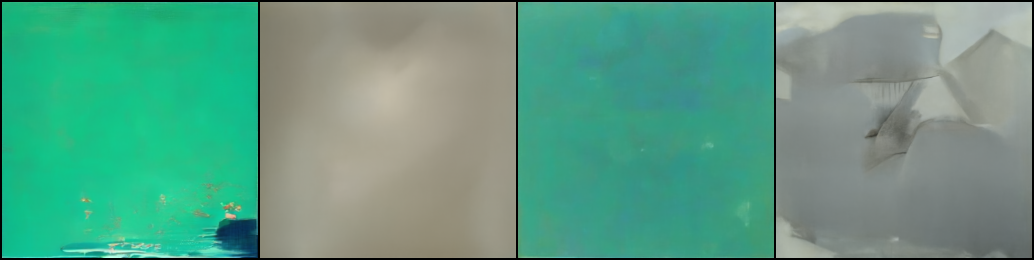

In [32]:
generator = torch.Generator(device=device).manual_seed(seed)

guidance_loss_scale = 40
x = torch.randn(4, 3, 256, 256, device=device, generator=generator)

for i, timestep in enumerate(tqdm(scheduler.timesteps)):
    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, timestep)
    
    # with torch.inference_mode():
    noise_pred = model(model_input, timestep).sample
    
    x0 = scheduler.step(noise_pred, timestep, x, generator=generator).pred_original_sample
    
    loss = color_loss(images=x0, target_color=(0.1, 0.9, 0.5)) * guidance_loss_scale
    if (i+1) % 10 == 0:
        print(f'Loss: {loss}')
    
    cond_grad = torch.autograd.grad(loss, x)[0]
    
    x = x.detach() - cond_grad
    
    x = scheduler.step(noise_pred, timestep, x, generator=generator).prev_sample

pred_images = x.cpu().clip(-1, 1) * 0.5 + 0.5
grid = tensor2pil(torchvision.utils.make_grid(pred_images, nrow=4))
display(grid)

### CLIP Guidance